In [1]:
!pip install langchain langgrapgh cassio

ERROR: Could not find a version that satisfies the requirement langgrapgh (from versions: none)
ERROR: No matching distribution found for langgrapgh

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import cassio
##connection of the Astra DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:lWKICZwJDdEJuRiZZAJnBFRN:a3880a6a8fb793c8a47f29b8e316907f20b927e2640a8dc0d96daf0a416039b6"
ASTRA_DB_ID="21bb147b-e6f2-4ebd-80df-dbbee0c0a0a1"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [5]:
!pip install langchain_community


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install -U tiktoken langchain-groq langchainhub langchain langgraph langchain_huggingface

     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.0 MB 218.8 kB/s eta 0:00:05
     --- ------------------------------------ 0.1/1.0 MB 255.1 kB/s eta 0:00:04
     --- ------------------------------------ 0.1/1.0 MB 255.1 kB/s eta 0:00:04
     ----- ---------------------------------- 0.1/1.0 MB 355.0 kB/s eta 0:00:03
     ------- -------------------------------- 0.2/1.0 MB 454.0 kB/s eta 0:00:02
     ------- -------------------------------- 0.2/1.0 MB 454.0 kB/s eta 0:00:02
     ------- ----------


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
###Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

#Docs to index
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",

]

##load
docs=[WebBaseLoader(url).load() for url in urls]
doc_list=[item for sublist in docs for item in sublist]
print(doc_list)
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,chunk_overlap=0)
docs_splits=text_splitter.split_documents(doc_list)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [22]:
docs_split

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [23]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [24]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(embedding=embeddings,
                             table_name="qa_mini_demo",
                             session=None,
                             keyspace=None
                             )

In [28]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_splits)
print("Inserted %i headlines." % len(docs_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [31]:
retriever=astra_vector_store.as_retriever()
retriever.invoke("what is agent")

[Document(id='71c56814efdc46dc9cb03f394008239f', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [32]:
##langgraph application
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field

In [33]:
#Data Model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource"""
    datasource:Literal["vectorstore","wiki_search"]=Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
        
    )

In [37]:
from langchain_groq import ChatGroq
from google.colab import userdata
import os
groq_api_key=userdata.get('groq_api_key')
print(groq_api_key)

ModuleNotFoundError: No module named 'google.colab'

In [41]:
llm=ChatGroq(groq_api_key=groq_api_key,model="Llama3.1-70b-Versatile")
llm

NameError: name 'groq_api_key' is not defined

In [42]:
structured_llm_router=llm.with_structured_output(RouteQuery)

NameError: name 'llm' is not defined

In [43]:
#Prompt
system="""You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents,prompt engineering and adversarial attacks.
Use the vectorstore for questions on these topics.Otherwise,use wiki-search"""
route_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system)
        ("human","{question}"),

    ]
)
question_router=route_prompt|structured_llm_router

<>:7: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:7: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\amitk\AppData\Local\Temp\ipykernel_13176\3673025577.py:7: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("system",system)
C:\Users\amitk\AppData\Local\Temp\ipykernel_13176\3673025577.py:7: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("system",system)
C:\Users\amitk\AppData\Local\Temp\ipykernel_13176\3673025577.py:7: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("system",system)
C:\Users\amitk\AppData\Local\Temp\ipykernel_13176\3673025577.py:7: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("system",system)


TypeError: 'tuple' object is not callable

In [44]:
print(question_router.invoke(
    {
        "question":"what is agent?"
    }
))

NameError: name 'question_router' is not defined

In [45]:
print(question_router.invoke(
    {
        "question":"who is shahrukh khan?"
    }
))

NameError: name 'question_router' is not defined

In [46]:
!pip install langchain_community
!pip install arxiv wikipedia


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [48]:
wiki.run("Tell me about shahrukh khan?")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Refe'

In [49]:
##Ai Agents application using Langgraph
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph

    Attributes:
        question:question
        generation:LLM generation
        documents:list of documents

    """
    question:str
    generation:str
    documents:List[str]

In [ ]:
from langchain.schema import document
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict):the current state
    Returns:
        state (dict):New key added to state,documents,that contains retrieved documents
    """

In [54]:
from langchain.schema import Document
def retrieve(state):
    """ 
    Retrieve documents
    Args:
    state(dict):The current graph state
    Returns:
        state (dict):New key added to state,documents, that contains retrieved documents
    """
    print("----Retrieve-----")
    questions=state["question"]

    ##Retrieval
    documents=retriever.invoke(questions)
    return {"documents":documents,"questions":questions}


In [55]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [64]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [65]:
from langgraph.graph import END,StateGraph,START
workflow=StateGraph(GraphState)
##Define the nodes
workflow.add_node("wiki_search",wiki_search)    #web search
workflow.add_node("retrieve",retrieve)          #retrieve

#Build the graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorestore":"retrieve",
    },

)
workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)

#compile
app=workflow.compile()

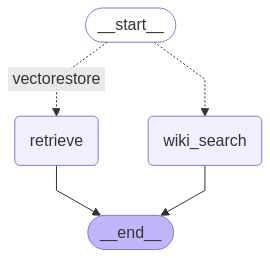

In [66]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [67]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---


NameError: name 'question_router' is not defined

In [63]:
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---


NameError: name 'question_router' is not defined